# PyTorchによるミニバッチ学習の実装

In [1]:
import torch
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

digits = load_digits()
X = digits.data
y = digits.target

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


In [2]:
def train_1epoch(model, train_loader, lossfun, optimizer, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)

        loss = lossfun(out, y)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()*x.size(0)

        _, pred = torch.max(out, 1)
        total_acc += torch.sum(pred == y.data)

    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_acc / len(train_loader.dataset)

    return avg_acc, avg_loss
    

In [3]:
import os
import random
import numpy as np
import torch

def seed_torch(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

100%|██████████| 29/29 [00:00<00:00, 1397.78it/s]


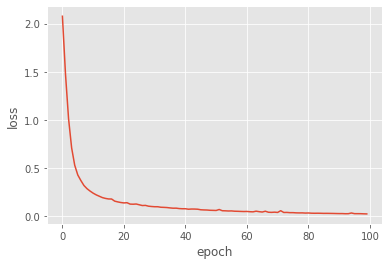

In [4]:
from torch import nn, optim 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

seed_torch()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

digits = load_digits()
X = digits.data
y = digits.target

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = nn.Sequential(
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10),
    )
model = model.to(device)

lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []

for ep in range(100):
    avg_acc, avg_loss = train_1epoch(model, train_loader, lossfun, optimizer, device)
    losses.append(avg_loss)

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("fig01-SGD-mini batch.png")